In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sb
from tqdm import tqdm
import pyfolio as pf

from scipy.stats import randint as sp_randint
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, roc_auc_score, roc_curve, auc
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV

current_dir = os.getcwd()

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (15,10)

pd.options.mode.chained_assignment = None  # default='warn'

/Users/danieloliveira/opt/anaconda3/lib/python3.8/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [5]:
file = open(os.path.join(current_dir, "data", "new_fxmm.pickle"), 'rb')
target_dict = pickle.load(file)

fast_signals = target_dict["signals"]["fast"]
slow_signals = target_dict["signals"]["slow"]
bars = target_dict["bars"]

In [2]:
def add_diff(data,
             periods):
    
    diff_list = []
    for name in data.columns:
        for p in range(1, periods + 1):
            diff_list.append(data[[name]].diff(periods=p).rename(columns={name: name + "_diff" + str(p)}))
    diff_df = pd.concat(diff_list, axis=1)
    
    data = pd.concat([data, diff_df], axis=1)
    return data

In [7]:
bkt_code = "USDZAR"
bar_name = "Close"
seed = 199402
init_step = 90
predict_step = 4
shifts = 0
periods = 2
param_distributions = {'C': np.linspace(0.001, 50, 200),
                       'l1_ratio': np.linspace(0.001, 0.999, 200)}
n_iter = 100
n_jobs = 4
n_splits = 5
ModelClass = LogisticRegression(fit_intercept=True, penalty='elasticnet', solver='saga', max_iter=500)
time_split = TimeSeriesSplit(n_splits=n_splits)
roc_auc_scorer = make_scorer(roc_auc_score)

In [8]:
bar_df = bars[bkt_code][[bar_name]].resample("W-FRI").last()

fast_signals_df = slow_signals[bkt_code]
slow_signals_df = slow_signals[bkt_code]
signals_df = ((fast_signals_df + slow_signals_df) / 2).ewm(span=5).mean().resample("W-FRI").last()

<AxesSubplot:xlabel='date'>

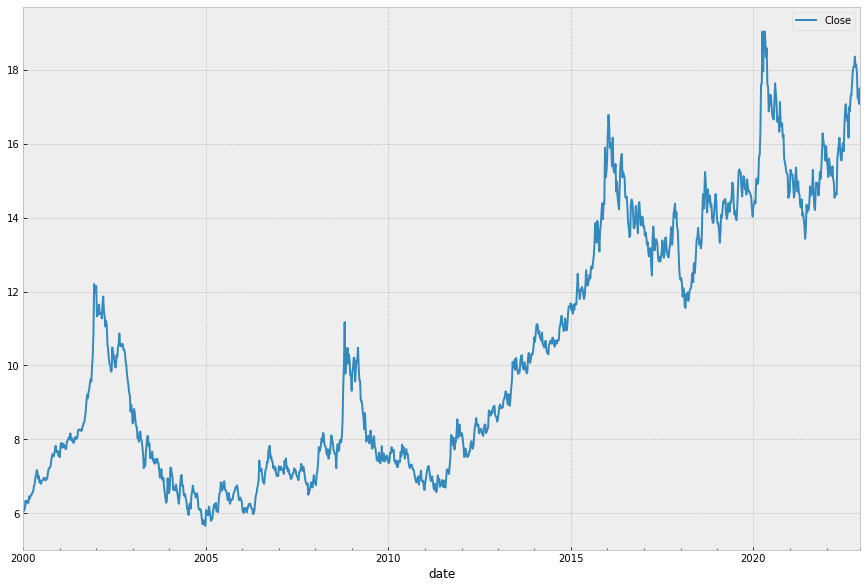

In [10]:
bar_df.plot()

<AxesSubplot:>

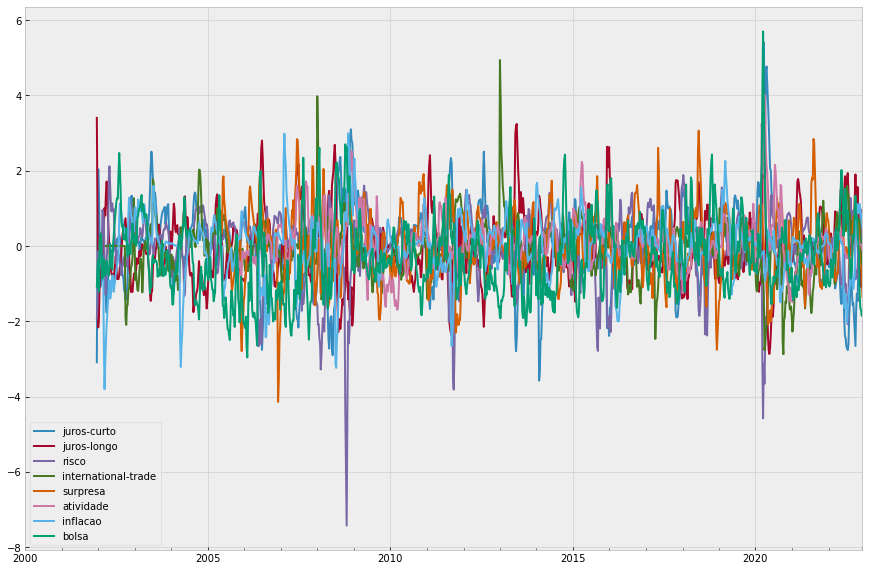

In [11]:
signals_df.plot()

In [12]:
if shifts != 0:
    signals_df = add_shift(data=signals_df,
                           shifts=shifts)

if periods != 0:
    signals_df = add_diff(data=signals_df,
                          periods=periods)

In [16]:
signals_df.describe().T

,count,mean,std,min,25%,50%,75%,max
juros-curto,1095.0,-0.009974,0.969152,-3.574859,-0.495510,0.024721,0.456966,5.409848
juros-longo,1095.0,-0.016228,0.863521,-2.867989,-0.541037,-0.069065,0.430609,4.505305
risco,1095.0,-0.036500,0.862499,-7.427413,-0.293163,0.079948,0.442560,2.117290
international-trade,1082.0,-0.067054,0.689638,-2.872455,-0.407264,-0.022093,0.273705,4.941926
surpresa,918.0,0.007544,0.884194,-4.141506,-0.526048,-0.026903,0.582879,3.064021
atividade,894.0,0.101132,0.658706,-1.691499,-0.278229,0.052709,0.397046,4.011593
inflacao,1091.0,-0.002049,0.750939,-3.801664,-0.346627,0.060931,0.391493,2.990821
bolsa,1095.0,-0.294459,0.975920,-2.959424,-0.964387,-0.356089,0.271577,5.701308
juros-curto_diff1,1094.0,0.002394,0.354471,-2.372837,-0.169362,0.003635,0.159926,3.324944
juros-curto_diff2,1093.0,0.001681,0.566931,-2.900510,-0.273577,-0.005701,0.281433,5.128675


<AxesSubplot:>

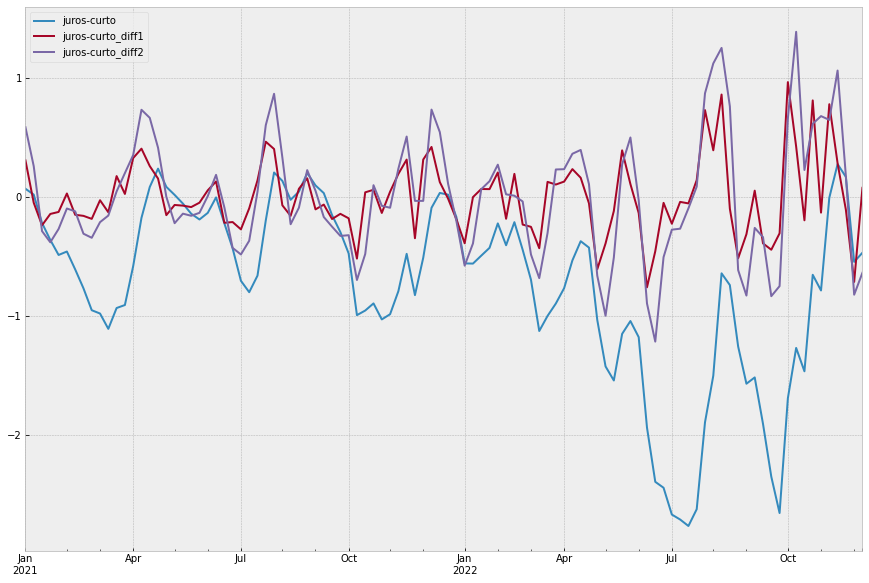

In [18]:
signals_df[["juros-curto", "juros-curto_diff1", "juros-curto_diff2"]].loc["2021-01-01":].plot()

In [20]:
y = bar_df[[bar_name]].pct_change()
X = signals_df
data = pd.concat([y, X], axis=1).dropna()

<AxesSubplot:>

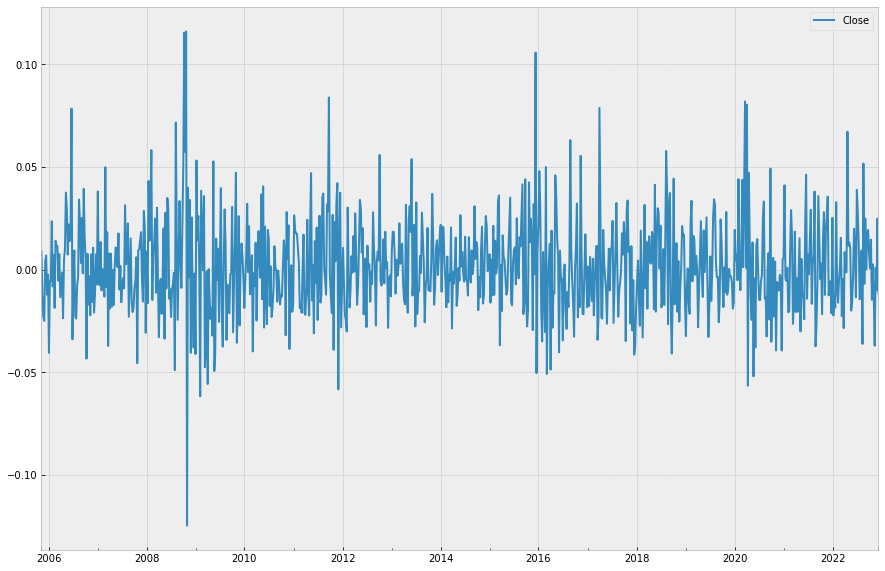

In [21]:
data[[bar_name]].plot()

In [22]:
data.tail()

,Close,juros-curto,juros-longo,risco,international-trade,surpresa,atividade,inflacao,bolsa,juros-curto_diff1,...,international-trade_diff1,international-trade_diff2,surpresa_diff1,surpresa_diff2,atividade_diff1,atividade_diff2,inflacao_diff1,inflacao_diff2,bolsa_diff1,bolsa_diff2
2022-11-11,-0.037093,-0.006912,-0.234263,0.690784,0.692337,-0.338138,0.032013,1.116401,-1.289777,0.778946,...,-0.035437,0.137002,-0.546832,-0.941047,-0.044823,-0.222281,0.002061,0.248976,-1.107838,-1.337267
2022-11-18,0.000940,0.276004,-0.595440,0.946323,0.302220,-0.556883,0.042169,0.888509,-1.649794,0.282917,...,-0.390117,-0.425554,-0.218745,-0.765577,0.010156,-0.034667,-0.227892,-0.225832,-0.360017,-1.467856
2022-11-25,-0.010118,0.168308,-1.085986,0.969038,-0.176245,-0.526187,0.032648,0.845110,-1.703858,-0.107696,...,-0.478465,-0.868582,0.030695,-0.188050,-0.009521,0.000635,-0.043399,-0.271291,-0.054064,-0.414081
2022-12-02,0.024817,-0.545419,-0.360656,0.275642,-0.547618,-0.712936,-0.026182,0.606744,-1.852298,-0.713728,...,-0.371373,-0.849838,-0.186748,-0.156053,-0.058830,-0.068351,-0.238366,-0.281765,-0.148439,-0.202504
2022-12-09,-0.011699,-0.468784,-0.393451,0.299643,-0.664145,-1.347213,-0.115842,0.505833,-1.769210,0.076636,...,-0.116527,-0.487900,-0.634277,-0.821025,-0.089660,-0.148490,-0.100911,-0.339276,0.083088,-0.065352


In [23]:
y_train = data[[bar_name]]
y_train.loc[y_train[bar_name] > 0, :] = 1
y_train.loc[y_train[bar_name] < 0, :] = 0
X_train = data.drop(bar_name, axis=1)

In [24]:
y_train.tail()

,Close
2022-11-11,0.0
2022-11-18,1.0
2022-11-25,0.0
2022-12-02,1.0
2022-12-09,0.0


In [26]:
X_train.columns

Index(['juros-curto', 'juros-longo', 'risco', 'international-trade',
       'surpresa', 'atividade', 'inflacao', 'bolsa', 'juros-curto_diff1',
       'juros-curto_diff2', 'juros-longo_diff1', 'juros-longo_diff2',
       'risco_diff1', 'risco_diff2', 'international-trade_diff1',
       'international-trade_diff2', 'surpresa_diff1', 'surpresa_diff2',
       'atividade_diff1', 'atividade_diff2', 'inflacao_diff1',
       'inflacao_diff2', 'bolsa_diff1', 'bolsa_diff2'],
      dtype='object')

In [35]:
i = init_step + 4
print(i)

y_loop = y_train.iloc[0:i]
X_loop = X_train.iloc[0:i]

y_loop_test = y_train[bar_name].iloc[i:(i + predict_step)]
X_loop_test = X_train.iloc[i:(i + predict_step)]

94


In [36]:
y_loop.tail()

,Close
2007-07-27,1.0
2007-08-03,1.0
2007-08-10,1.0
2007-08-17,1.0
2007-08-24,0.0


In [37]:
y_loop_test

2007-08-31    0.0
2007-09-07    1.0
2007-09-14    0.0
2007-09-21    0.0
Freq: W-FRI, Name: Close, dtype: float64

In [ ]:
results = []
count = 1
for i in tqdm(range(init_step, (y_train.shape[0] - init_step), predict_step),
              total=((y_train.shape[0] - init_step * 2) // predict_step + 1),
              desc="Backtest " + bkt_code):
    y_loop = y_train.iloc[0:i]
    X_loop = X_train.iloc[0:i]

    y_loop_test = y_train[bar_name].iloc[i:(i + predict_step)]
    X_loop_test = X_train.iloc[i:(i + predict_step)]

    model_search = RandomizedSearchCV(estimator=ModelClass,
                                      param_distributions=param_distributions,
                                      n_iter=n_iter,
                                      cv=time_split,
                                      verbose=False,
                                      n_jobs=n_jobs,
                                      scoring=roc_auc_scorer,
                                      random_state=seed)
    model_search = model_search.fit(X_loop.to_numpy(), y_loop.to_numpy().ravel())
    test_pred = model_search.best_estimator_.predict_proba(X_loop_test)[:, 1]
    dict_ = {"date": y_loop_test.index,
             "return_direction": y_loop_test.values,
             "prediction": test_pred}
    result = pd.DataFrame(dict_)
    results.append(result)

results_df = pd.concat(results, axis=0)
results_df.loc[results_df["prediction"] > 0.55, "prediction_class"] = 1
results_df.loc[results_df["prediction"] < 0.45, "prediction_class"] = -1
results_df.loc[(results_df["prediction"] => 0.45) & (results_df["prediction"] <= 0.55), "prediction_class"] = 0
results_df.set_index("date", inplace=True)

tmp_backtest_df = pd.concat([bar_df.pct_change(), results_df[["prediction_class"]]], axis=1).dropna()
tmp_backtest_df[bkt_code] = tmp_backtest_df["Close"] * tmp_backtest_df["prediction_class"]

backtest.append(tmp_backtest_df[[bkt_code]])

# calculate scores
lr_auc = roc_auc_score(results_df["return_direction"], results_df["prediction"])
aucs[bkt_code] = lr_auc